In [1]:
import PyQt5
# !pip install PyQt5
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation

from IPython.display import HTML


My attempt at 1d AWE

Refs: 

- http://hplgit.github.io/num-methods-for-PDEs/doc/pub/wave/pdf/wave-4print-A4-2up.pdf
- https://github.com/hplgit/INF5620/blob/gh-pages/src/wave/wave1D_dn.py
- http://hplgit.github.io/INF5620/doc/notes/main_wave.html#wave:string
- https://en.wikipedia.org/wiki/Neumann_boundary_condition
- https://en.wikipedia.org/wiki/Dirichlet_boundary_condition

- https://github.com/jshragge/CSM_GP_GEOPCOMP/blob/master/10_Hyperbolic_PDEs.ipynb
- https://github.com/jshragge/CSM_GP_GEOPCOMP/blob/master/09_Parabolic_PDEs.ipynb
- https://github.com/jshragge/CSM_GP_GEOPCOMP/blob/master/08_Elliptical_PDEs.ipynb
- https://github.com/jshragge/CSM_GP_GEOPCOMP/blob/master/07_Differentiation.ipynb
- https://en.wikipedia.org/wiki/Finite_difference_coefficient

- https://github.com/devitocodes/devito/blob/master/examples/userapi/04_boundary_conditions.ipynb


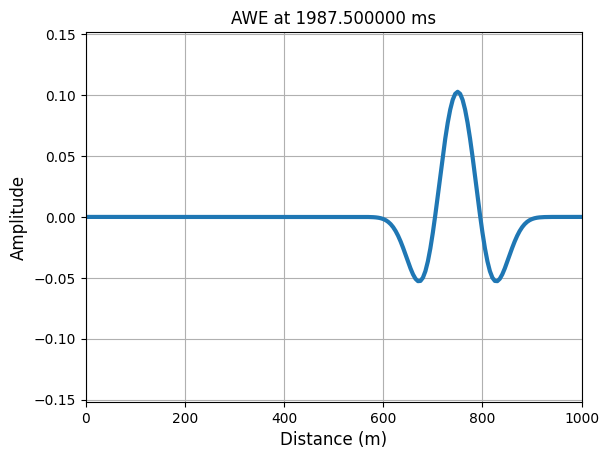

In [6]:
## Define spatial grid
L  = 1000               # . . String length (mm)
nx = 201                # . . Number of points in discretization (dimensions of wavefield)
dx = L/(nx-1)           # . . Discretization interval
x = np.linspace(0,L,nx) # . . Xline
v  = 1000               # . . Velocity (mm/s)

## Time stepping parameters
CC = 0.5     # . . Courant number
nt = 800     # . . Number of time steps
dt = CC*dx/v # . . Define dt based on Courant number

## Define Courant number (squared)
C2 = (v*dt/dx)**2

## Initialise wavefields on spatial grid
Up1 = np.zeros((nx))
U = np.zeros((nx))
Um1 = np.zeros((nx))
solution = np.zeros((nx,nt)) 

## Define Initial waveform
ss=40   # sigma for Ricker wavelet
U = 2/np.sqrt(3*ss*np.sqrt(np.pi))*(1-((x-3*L/4     )/ss)**2)*np.exp(-(x-3*L/4     )**2/(2*ss**2))

## Define previous time step at t=-∆t
# Um1 = 2/np.sqrt(3*ss*np.sqrt(np.pi))*(1-((x-3*L/4-dt*v)/ss)**2)*np.exp(-(x-3*L/4-dt*v)**2/(2*ss**2))

# Modified stencil formula for the first step (handle negative time grid point)
for i in range(1, nx-1):
    Up1[i] = U[i] - 0.5*C2*(U[i+1] - 2*U[i] + U[i-1])  

    # U[i] = Um1[i] - 0.5*C2*(Um1[i+1] - 2*Um1[i] + Um1[i-1])  

# Select boundary conditions - two options
#   1. Dirchlet BC (flips polarity upon reflection)
#       Specifies the values that a solution needs to take along the boundary of the domain:
#       -> u = 0 at boundary
#       For i=0, U_i = 0; 
#       For i=nx, U_i = 0
#
#   2. Neumann BC (preserves sign of reflection at boundary)
#       Specifies the values for the derivative applied at the boundary of the domain:
#       -> du/dn = 0 at boundary 
#       For i=0, U_i-1 == U_i+1; 
#       For i=nx, U_nx+1 == U_nx-1

neumann = True
if neumann is not True:
    dirchlet = True

# Set boundary conditions for time step 0
if neumann: # Modify stencil for Neumann boundary conditions at domain boundary
    i = 0 # for i = 0
    Up1[i] = -Um1[i] + 2*U[i] + 2*C2*(U[i+1] - U[i])

    i = nx-1 # for i = Nx
    Up1[i] = -Um1[i] + 2*U[i] + 2*C2*(U[i-1] - U[i])

elif dirchlet: # Assign values to that solution at domain boundary
    Up1[0] = 0; Up1[nx-1] = 0

# Save solution for timestep == 0
t = 0
solution[:,t] = Up1

# Update wavefields for next time step
Um1 = U.copy()
U = Up1.copy()

# Loop for remaining time steps
for t in range(1,nt):

    # Calculate solution for all x
    for i in range(0,nx-1):
        Up1[i] = 2*U[i] - Um1[i] + C2*(U[i+1] - 2*U[i] + U[i-1])
        
    # Set boundary conditions for current time step
    if neumann: # Modify stencil for Neumann boundary conditions at domain boundary
        i = 0 # for i = 0
        Up1[i] = -Um1[i] + 2*U[i] + 2*C2*(U[i+1] - U[i])

        i = nx-1 # for i = Nx
        Up1[i] = -Um1[i] + 2*U[i] + 2*C2*(U[i-1] - U[i])

    elif dirchlet: # Assign values to that solution at domain boundary
        Up1[0] = 0; Up1[nx-1] = 0

    # Save solution for current time step
    solution[:,t] = Up1    

    # Update wavefields for next time step
    Um1 = U.copy() 
    U = Up1.copy()



# Animate solution
fig1 = plt.figure()
ax1 = fig1.add_subplot(1,1,1)
k = 0
nskip=5

## 1D animation function
def AWE_1D_animate(i):
    global k
    ax1.clear()
    amax = np.max(np.abs(solution))
    plt.plot(x,solution[:,k],linewidth=3)
    plt.grid(True)
    plt.xlim([0,L])
    plt.ylim(-1.1*amax,1.1*amax)
    plt.xlabel('Distance (m)',fontsize=12);
    plt.ylabel('Amplitude',fontsize=12);
    plt.title('AWE at %f ms'%(k*dt*1000))
    k += nskip  # 1

# . . Call the animator. 
anim1 = animation.FuncAnimation(fig1,AWE_1D_animate,frames=int((nt-2*nskip)/nskip),interval=50)

HTML(anim1.to_html5_video())

